In [ ]:
## Load packages

import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from scipy import stats
from scipy.stats import spearmanr
import copy
from collections import defaultdict
from tqdm import tqdm

from terminator.utils.common import ints_to_seq_torch
from terminator.utils.model import loss_fn
import importlib
importlib.reload(loss_fn) ## Reload in case changes were made to loss_fn
calc_eners_stability = loss_fn.calc_eners_stability

In [ ]:
## Load util functions

%run 2025_02_06_run_model_utils.ipynb

In [ ]:
dataset = '../pdbs' ## Directory containing .pdb files
pdb_list = ['3PK1.pdb'] ## List of .pdb files to run on
dev = 'cpu' ## Device to run on (change to cuda:{device_id} if running with a GPU)
model_dir = '../models/coordinator' ## Default model (do not change)
ener_data_file = "../ener_data/test_seq_ener.csv" # '../ener_data/3PK1_ener.csv' #None ## Benchmark energy data (None if no energy data to provide; Use this example to know what column headers to use)
adj_index = False ## Indicates if the 'pos' column of the energy data benchmark uses the indices in the .pdb file (which can be nonconsecutive) or are consecutive integers
seq_df = True ## Indicates whether the ener_data_file contains just sequences and energies (in columns named 'seqs', and 'ener')
args = model_args(dataset = dataset,
                 model_dir = model_dir, #
                 dev=dev,
                 checkpoint='net_best_checkpoint.pt',
                 pdb_list=pdb_list,
                 ener_data=ener_data_file,
                 adj_index=adj_index,
                 seq_df=seq_df
                 ) 
## 

model_vars = get_model_and_data(args)
model, dataloader, _, _, _, _, _, _, run_hparams, model_hparams = model_vars


In [ ]:
model = model.eval()

In [ ]:
run_hparams['loss_config'] = {"nlcpl": 1, "loss_smoothed": 1, "stability_loss": 1}
## nlcpl: Potts model loss
## loss_smoothed: Sequence recovery loss
## stability_loss: energy loss
loss_fn_real = loss_fn.construct_loss_fn(run_hparams)

In [ ]:
## If no energy data provided, create synthetic sequences representing a DMS screen
mut_aa_encoded = torch.arange(20)
if ener_data_file is None:
    new_dataloader = []
    for data in dataloader:
        sort_seqs = []
        for pos in range(data['seqs'].shape[1]):
            wt_aa_encoded = data['seqs'][0,pos].cpu().item()
            for mut_ind in range(20):
                if mut_ind == wt_aa_encoded:
                    continue
                mut_seq = copy.deepcopy(data['seqs'])
                mut_seq[0,pos] = mut_ind
                sort_seqs.append(mut_seq)

        sort_seqs = torch.stack(sort_seqs, dim=1)
        sort_nrgs = -1*torch.ones((1, sort_seqs.shape[1]))
        data['sortcery_seqs'] = sort_seqs
        data['sortcery_nrgs'] = sort_nrgs
        new_dataloader.append(copy.deepcopy(data))
    dataloader = new_dataloader

In [ ]:
## Run COORDinator and output Potts losses, sequence losses, energy losses, and all energy predictions

out_dir = '../ener_preds'
pdb_losses = {'Protein': [], 'Potts': [], 'Sequence': [], 'NSR': [], 'Energy': []}

return_all_preds = True

with torch.no_grad():
    for data in tqdm(dataloader):
        pdb = data['ids'][0]
   
        max_seq_len = max(data['seq_lens'].tolist())
        etab, h_V, _, E_idx, _, _ = model(data, max_seq_len)
        batch_loss_dict = loss_fn_real(etab, h_V, None, None, E_idx, None, copy.deepcopy(data), None, None, None, 
                                      None, None, False, None)
        pdb_losses['Protein'].append(pdb)
        pdb_losses['Potts'].append(batch_loss_dict['nlcpl']['loss'].cpu().item())
        pdb_losses['Sequence'].append(batch_loss_dict['loss_smoothed']['loss'].cpu().item())
        pdb_losses['NSR'].append(batch_loss_dict['loss_smoothed']['nsr'].cpu().item())
        if ener_data_file is not None and type(batch_loss_dict['stability_loss']['loss']) is not int:
            pdb_losses['Energy'].append(batch_loss_dict['stability_loss']['loss'].cpu().item())
        else:
            pdb_losses['Energy'].append(np.nan)
        
        if return_all_preds:
            mut_file = os.path.join(out_dir, f"COORD_pred_{pdb}.csv")
            b, n, k, h = etab.shape
            h = int(np.sqrt(h))
            etab = etab.view(b, n, k, h, h)
            pad = (0, 2, 0, 2)
            etab = F.pad(etab, pad, "constant", 0)
            predicted_E, ref_seqs, ref_energies = calc_eners_stability(etab, E_idx, data['sortcery_seqs'], data['sortcery_nrgs'])
            if predicted_E.shape[0] > 1:
                norm_pred = predicted_E - torch.mean(predicted_E) 
                norm_ref = ref_energies - torch.mean(ref_energies)
            else:
                norm_pred = predicted_E
                norm_ref = ref_energies
            
            pdb_stats = save_preds(norm_pred, ref_seqs, data['seqs'][0], pdb)
            pdb_df = pd.DataFrame(pdb_stats).sort_values(by=['pos', 'mutant'], ascending=[True, True])
            pdb_df.to_csv(mut_file, index=None)

pdb_losses = pd.DataFrame(pdb_losses)

In [ ]:
predicted_E.shape

In [23]:
type(batch_loss_dict['stability_loss']['loss']) is not int

False

In [17]:
batch_loss_dict['stability_loss']['loss']

0

In [9]:
data['sortcery_seqs'].shape, data['sortcery_nrgs'].shape, etab.shape

(torch.Size([1, 4, 156]), torch.Size([1, 4]), torch.Size([1, 160, 30, 400]))

In [10]:
"".join(ints_to_seq_torch(data['seqs'][0]))

'SLYRQSLEIISRYLREQATGAKATSRKALETLRRVGDGVQRNHETAFQGMLRKLDIKNEDDVKSLSRVMIHVFSDGVTNWGRIVTLISFGAFVAKHLKTINQESCIEPLAESITDVLVRTKRDWLVKQRGWDGFVEFFHVSTKKLSECLKRIGDELDSNM'

In [11]:
'SLYRQSLEIISRYLREQATGAKALETLRRVGDGVQRNHETAFQGMLRKLDIKNEDDVKSLSRVMIHVFSDGVTNWGRIVTLISFGAFVAKHLKTINQESCIEPLAESITDVLVRTKRDWLVKQRGWDGFVEFFHVESTKKLSECLKRIGDELDSNM'

'SLYRQSLEIISRYLREQATGAKALETLRRVGDGVQRNHETAFQGMLRKLDIKNEDDVKSLSRVMIHVFSDGVTNWGRIVTLISFGAFVAKHLKTINQESCIEPLAESITDVLVRTKRDWLVKQRGWDGFVEFFHVESTKKLSECLKRIGDELDSNM'

In [173]:
## Display losses
pdb_losses

,Protein,Potts,Sequence,NSR,Energy
0,3PK1.pdb,1.901406,1.667682,0.55625,0.557569


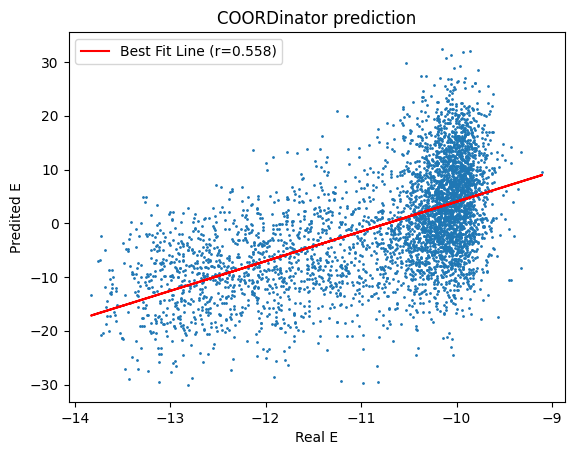

In [174]:
## Example analysis showing how to merge predicted and real energies
ener_df = pd.read_csv('../ener_data/3PK1_ener.csv')
merge_df = ener_df.merge(pdb_df[['mutation', 'pred_ener']], on='mutation')

## Example plotting (1st argument is real energies; 2nd argument is predicted energies)
plot_scatter_list(merge_df['ener'], merge_df['pred_ener'], 'COORDinator prediction')